# 预测测试集中的所有图像

使用训练好的图像分类模型，预测测试集的所有图像，得到预测结果表格。

同济子豪兄：https://space.bilibili.com/1900783

[代码运行云GPU环境](https://featurize.cn/?s=d7ce99f842414bfcaea5662a97581bd1)：GPU RTX 3060、CUDA v11.2

## 导入工具包

In [18]:
from tqdm import tqdm

import pandas as pd
import numpy as np

import torch

from PIL import Image

# 有 GPU 就用 GPU，没有就用 CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device', device)

device cuda:0


## 图像预处理

In [1]:
from torchvision import transforms

# 训练集图像预处理：缩放裁剪、图像增强、转 Tensor、归一化
train_transform = transforms.Compose([transforms.RandomResizedCrop(224),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                     ])

# 测试集图像预处理-RCTN：缩放、裁剪、转 Tensor、归一化
test_transform = transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize(
                                         mean=[0.485, 0.456, 0.406], 
                                         std=[0.229, 0.224, 0.225])
                                    ])

## 导入训练好的模型

In [4]:
# !wget https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20220716-mmclassification/checkpoints/melon17_pytorch_20220812.pth -O checkpoints/melon17_pytorch_20220812.pth


In [6]:
model = torch.load('checkpoints/melon17_pytorch_20220813.pth')
model = model.eval().to(device)

## 抽取模型中间层输出结果作为语义特征

In [7]:
from torchvision.models.feature_extraction import create_feature_extractor

In [8]:
# model

In [9]:
model_trunc = create_feature_extractor(model, return_nodes={'avgpool': 'semantic_feature'})

## 计算单张图像的语义特征

In [53]:
img_path = 'melon17_split/val/丝瓜/109.jpg'
img_pil = Image.open(img_path)
input_img = test_transform(img_pil) # 预处理
input_img = input_img.unsqueeze(0).to(device)
# 执行前向预测，得到所有类别的 logit 预测分数
pred_logits = model_trunc(input_img) 

In [54]:
pred_logits['semantic_feature'].squeeze().detach().cpu().numpy().shape

(512,)

In [56]:
# pred_logits['semantic_feature'].squeeze().detach().cpu().numpy()

## 计算测试集所有图像的语义特征

In [19]:
df = pd.read_csv('测试集预测结果.csv')

In [20]:
df

,图像路径,标注类别ID,标注类别名称,top-1-预测ID,top-1-预测名称,top-2-预测ID,top-2-预测名称,top-3-预测ID,top-3-预测名称,top-n预测正确,...,甜瓜-伊丽莎白-预测置信度,甜瓜-白-预测置信度,甜瓜-绿-预测置信度,甜瓜-金-预测置信度,白兰瓜-预测置信度,羊角蜜-预测置信度,苦瓜-预测置信度,西瓜-预测置信度,西葫芦-预测置信度,黄瓜-预测置信度
0,melon17_split/val/丝瓜/109.jpg,0,丝瓜,0.0,丝瓜,2.0,佛手瓜,3.0,冬瓜,1.0,...,9.523736e-04,0.030351,2.757894e-03,0.001186,0.006929,0.067797,0.000739,0.000354,0.000387,0.000415
1,melon17_split/val/丝瓜/111.jpg,0,丝瓜,0.0,丝瓜,13.0,苦瓜,12.0,羊角蜜,1.0,...,5.072762e-06,0.000035,3.856440e-05,0.000017,0.000019,0.053255,0.390125,0.000016,0.022746,0.047281
2,melon17_split/val/丝瓜/113.jpg,0,丝瓜,0.0,丝瓜,3.0,冬瓜,5.0,哈密瓜,1.0,...,3.860593e-03,0.026654,4.844100e-04,0.001215,0.018729,0.044135,0.003808,0.002478,0.028452,0.026643
3,melon17_split/val/丝瓜/115.jpg,0,丝瓜,3.0,冬瓜,0.0,丝瓜,15.0,西葫芦,1.0,...,4.303373e-05,0.000446,1.275594e-03,0.000010,0.000909,0.001886,0.017619,0.000474,0.048292,0.018403
4,melon17_split/val/丝瓜/120.jpg,0,丝瓜,0.0,丝瓜,15.0,西葫芦,13.0,苦瓜,1.0,...,8.444517e-05,0.000010,2.361687e-05,0.000345,0.000055,0.004827,0.055491,0.000097,0.084968,0.029771
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
504,melon17_split/val/黄瓜/85.jpeg,16,黄瓜,0.0,丝瓜,16.0,黄瓜,13.0,苦瓜,1.0,...,2.438154e-04,0.000499,1.096880e-03,0.000878,0.001492,0.050605,0.154425,0.029378,0.006127,0.295208
505,melon17_split/val/黄瓜/91.png,16,黄瓜,16.0,黄瓜,13.0,苦瓜,0.0,丝瓜,1.0,...,1.512831e-05,0.000341,2.605401e-05,0.000040,0.000214,0.003099,0.107053,0.000007,0.000135,0.865623
506,melon17_split/val/黄瓜/92.jpg,16,黄瓜,15.0,西葫芦,16.0,黄瓜,0.0,丝瓜,1.0,...,9.734586e-06,0.000005,6.072431e-07,0.000009,0.000012,0.002433,0.000762,0.000098,0.558286,0.281522
507,melon17_split/val/黄瓜/96.png,16,黄瓜,16.0,黄瓜,13.0,苦瓜,0.0,丝瓜,1.0,...,1.915214e-05,0.000025,2.207602e-06,0.000039,0.000081,0.002738,0.042326,0.000079,0.000274,0.928848


In [21]:
encoding_array = []

for idx, row in tqdm(df.iterrows()):
    img_path = row['图像路径']
    img_pil = Image.open(img_path).convert('RGB')
    input_img = test_transform(img_pil).unsqueeze(0).to(device) # 预处理
    feature = model_trunc(input_img)['semantic_feature'].squeeze().detach().cpu().numpy() # 执行前向预测，得到 avgpool 层输出的语义特征
    encoding_array.append(feature)
encoding_array = np.array(encoding_array)

509it [00:07, 69.21it/s]


In [23]:
encoding_array.shape

(509, 512)

## 语义特征降维

In [22]:
# 降维到二维
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, n_iter=10000)
X_tsne = tsne.fit_transform(encoding_array)

/environment/miniconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/environment/miniconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [24]:
X_tsne.shape

(509, 2)

## 语义特征可视化

### 设置matplotlib中文字体

In [25]:
# # windows操作系统
# plt.rcParams['font.sans-serif']=['SimHei']  # 用来正常显示中文标签 
# plt.rcParams['axes.unicode_minus']=False  # 用来正常显示负号

In [26]:
# Mac操作系统，参考 https://www.ngui.cc/51cto/show-727683.html
# 下载 simhei.ttf 字体文件
# !wget https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20220716-mmclassification/dataset/SimHei.ttf

In [27]:
# Linux操作系统，例如 云GPU平台：https://featurize.cn/?s=d7ce99f842414bfcaea5662a97581bd1
# 如果遇到 SSL 相关报错，重新运行本代码块即可
!wget https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20220716-mmclassification/dataset/SimHei.ttf -O /environment/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/SimHei.ttf
!rm -rf /home/featurize/.cache/matplotlib

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc("font",family='SimHei') # 中文字体
plt.rcParams['axes.unicode_minus']=False  # 用来正常显示负号

--2022-08-13 23:04:22--  https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20220716-mmclassification/dataset/SimHei.ttf
Connecting to 172.16.0.13:5848... connected.
Proxy request sent, awaiting response... 200 OK
Length: 10050868 (9.6M) [application/x-font-ttf]
Saving to: ‘/environment/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/SimHei.ttf’

/environment/minico 100%[===================>]   9.58M  21.9MB/s    in 0.4s    

2022-08-13 23:04:23 (21.9 MB/s) - ‘/environment/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/SimHei.ttf’ saved [10050868/10050868]



### 可视化配置

In [28]:
import seaborn as sns
marker_list = ['^','+','x','o','s','d','D','*','X','3','P','v','1','2','3','4','8','h','H']

In [29]:
class_list = np.unique(df['标注类别名称'])

In [30]:
class_list

array(['丝瓜', '人参果', '佛手瓜', '冬瓜', '南瓜', '哈密瓜', '木瓜', '甜瓜-伊丽莎白', '甜瓜-白',
       '甜瓜-绿', '甜瓜-金', '白兰瓜', '羊角蜜', '苦瓜', '西瓜', '西葫芦', '黄瓜'],
      dtype=object)

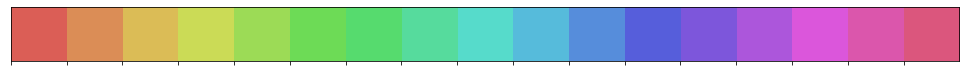

In [31]:
n_class = len(class_list) # 测试集标签类别数
palette = sns.hls_palette(n_class) # 配色方案
sns.palplot(palette)

In [50]:
# 随机打乱颜色列表和点型列表
import random
random.seed(1234)
random.shuffle(marker_list)
random.shuffle(palette)

### 可视化测试集语义特征和对应的`标注类别`

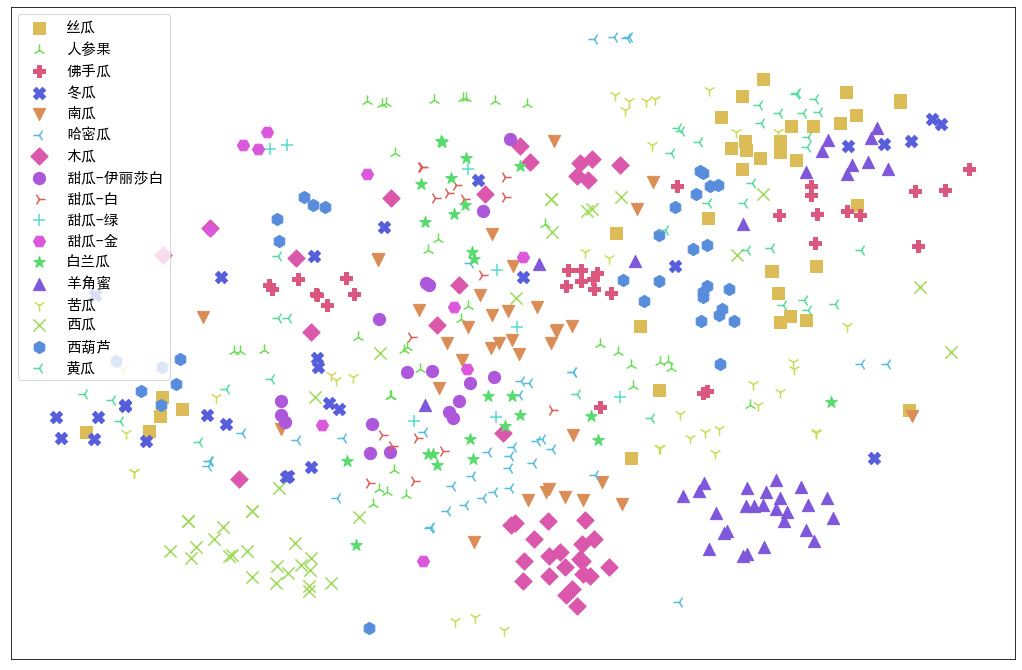

In [51]:
plt.figure(figsize=(18, 12))
for idx, fruit in enumerate(class_list): # 遍历每个类别
    # 获取颜色和点型
    color = palette[idx]
    marker = marker_list[idx%len(marker_list)]
    
    # 找到所有标注类别为当前类别的图像索引号
    indices = np.where(df['标注类别名称']==fruit)
    plt.scatter(X_tsne[indices, 0], X_tsne[indices, 1], color=color, marker=marker, label=fruit, s=150)

plt.legend(fontsize=15, markerscale=1)
plt.xticks([])
plt.yticks([])
plt.savefig('语义特征和标注类别.pdf', dpi=300) # 保存图像
plt.show()

### 可视化测试集语义特征和对应的`预测类别`

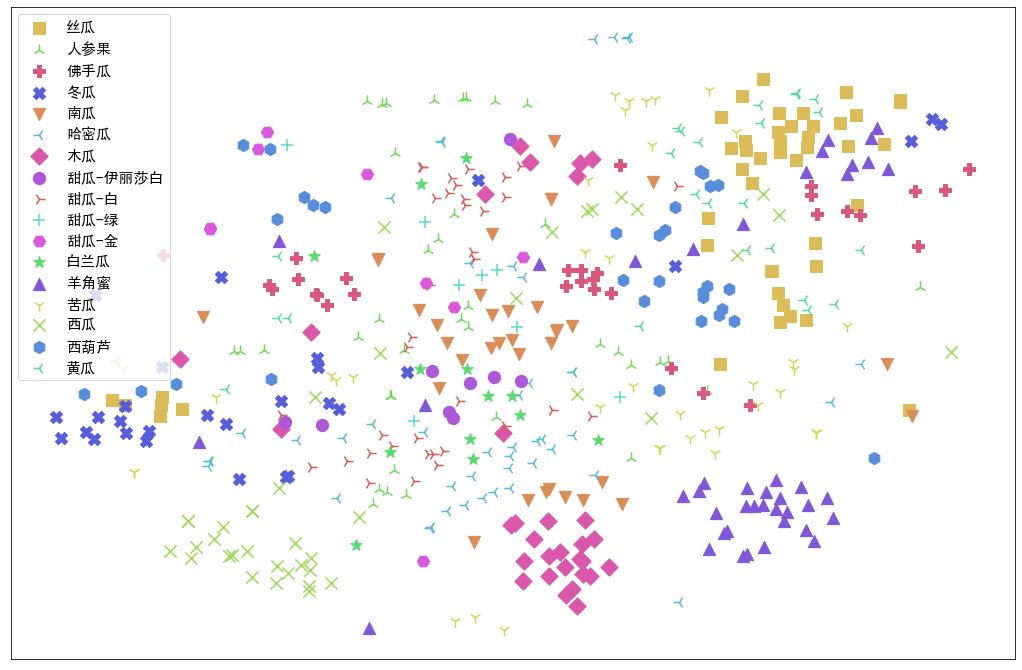

In [52]:
plt.figure(figsize=(18, 12))
for idx, fruit in enumerate(class_list): # 遍历每个类别
    # 获取颜色和点型
    color = palette[idx]
    marker = marker_list[idx%len(marker_list)]
    
    # 找到所有标注类别为当前类别的图像索引号
    indices = np.where(df['top-1-预测名称']==fruit)
    plt.scatter(X_tsne[indices, 0], X_tsne[indices, 1], color=color, marker=marker, label=fruit, s=150)

plt.legend(fontsize=15, markerscale=1)
plt.xticks([])
plt.yticks([])
plt.savefig('语义特征和预测类别.pdf', dpi=300) # 保存图像
plt.show()

## 扩展阅读

【斯坦福CS231N】可视化卷积神经网络：https://www.bilibili.com/video/BV1K7411W7So

五万张ImageNet 验证集图像的语义特征降维可视化：https://cs.stanford.edu/people/karpathy/cnnembed/

## 思考题

- 语义特征可以取训练集图像计算得到吗？为什么？

- 可视化`标注类别`和`预测类别`有什么不同？说明了什么？

- 取由浅至深不同中间层的输出结果作为语义特征，效果会有何不同？

- ”神经网络的强大之处，就在于，输入无比复杂的图像像素分布，输出在高维度线性可分的语义特征分布，最后一层分类层就是线性分类器"。如何理解这句话？

- 如何进一步改进语义特征的可视化？（三维、交互点击显示图片）

- 如何做出扩展阅读里第二个链接的效果？